This is a simple example of Gaussian Process regression. The model is that you've got some set of training inputs $x_1, \cdots x_N$ and test inputs $x_{N+1}, \cdots, x_{N+M}$, and a kernel function $k$. Then:

\begin{aligned}
K_{ij} \leftarrow & k(x_i,x_j), & i,j \in \{1,\cdots,N+M\} \\
z \sim & \mathrm{Normal}(0,K) \\
\sigma \sim & \mathrm{Exponential}(1) \\
y_i \sim & \mathrm{Normal}(z_i,\sigma^2), & i \in \{1,\cdots,N+M\} \\
\end{aligned}

However, we only observe $y_i$ for the training inputs. So if there are $M < N$ training inputs we are interested in the posterior distribution of

$$ p(y_{N+1:N+M} \vert y_{1:N}). $$

There's no need for any other math—inference does it all for you.

This is in reality a fairly "hard" inference problem, so I use 5000 iterations of sampling which is pretty slow. Probably HMC sampling would work better than Gibbs.

plot the mean and std


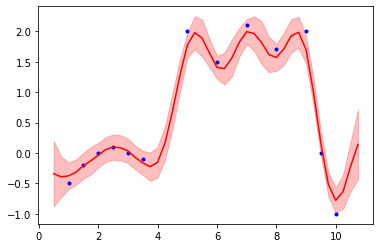

In [10]:
from pangolin import d, t, Given, vmap, sample, E, std
from matplotlib import pyplot as plt
import numpy as np

def kernel(x):
    N = len(x)
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = np.exp(-1*(x[i]-x[j])**2)
    # make PSD
    return .5*(K+K.T) + .01*np.eye(N)

# training data
x_train = [   1, 1.5,2,2.5,3, 3.5,5,  6,  7,  8,9,9.5,10]
y_train = [-0.5,-0.2,0,0.1,0,-0.1,2,1.5,2.1,1.7,2,  0,-1]
N = len(x_train)
x_test = np.arange(0.5,11,.25) # the "test" data is just a range

x = np.concatenate([x_train,x_test])

# the model
K = kernel(x)                # compute kernel matrix
np.linalg.cholesky(K)        # just to check posdef
σ = d.exp(1)                 # noise
z = d.mnorm_vcov(np.zeros(len(x)),K)
y = vmap(d.norm,[True,False])(z,1/σ**2) # JAGS uses precision

print('plot the mean and std')
y_pred_mean = E(y[N:],Given(y[:N]==y_train),niter=5000)
y_pred_std  = std(y[N:],Given(y[:N]==y_train),niter=5000)
y_lo = y_pred_mean - y_pred_std
y_hi = y_pred_mean + y_pred_std
plt.figure()
plt.plot(x_train,y_train,'b.')
plt.plot(x_test,y_pred_mean,'r-');
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.25);